In [1]:
%matplotlib inline
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time

from emcee import EnsembleSampler
from fleck import Star
from lightkurve import search_lightcurvefile
from corner import corner
from celerite import GP, terms, modeling

lcf = search_lightcurvefile('AU Mic', mission='TESS').download()
lc = lcf.get_lightcurve('PDCSAP_FLUX')

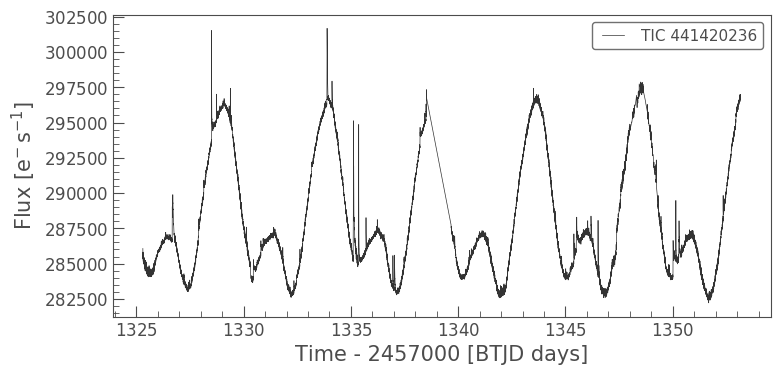

In [2]:
skip = 50
astropy_time = Time(lc.time[~np.isnan(lc.flux)][::skip] + 2457000, format='jd')
flux_observed = lc.flux[~np.isnan(lc.flux)][::skip] / np.nanmin(lc.flux)
err_observed = lc.flux_err[~np.isnan(lc.flux)][::skip] / np.nanmin(lc.flux)

lc.plot()

In [3]:
prot = 4.865
star = Star(spot_contrast=10, u_ld=[0.4, 0.2], rotation_period=prot, 
            phases=(astropy_time.jd % prot) / prot)

init_lons = np.array([60, 220])
init_lats = np.array([0, 30])
init_rads = np.array([0.07, 0.04])

lons = init_lons[:, None] * u.deg
lats = init_lats[:, None] * u.deg
rads = init_rads[:, None]

flux_model = star.light_curve(lons, lats, rads, inc_stellar=90*u.deg, times=astropy_time.jd)

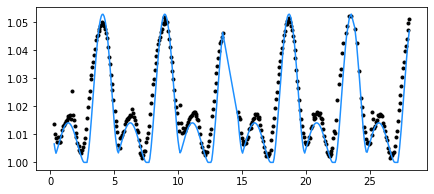

In [4]:
fig, ax = plt.subplots(figsize=(7, 3), sharex=True)
btjd_mid = int(astropy_time.jd.min())

ax.plot(astropy_time.jd - btjd_mid, 
           flux_observed, 'k.')

ax.plot(astropy_time.jd - btjd_mid, 
           flux_model, color='DodgerBlue')
plt.show()

In [33]:
yerr = 0.0001


class MeanModel(modeling.Model):
    parameter_names = ("lon0", "lon1", "lat0", "lat1", "rad0", "rad1")

    def get_value(self, t):
        lons = [[self.lon0], [self.lon1]]
        lats = [[self.lat0], [self.lat1]]
        rads = np.array([[self.rad0], [self.rad1]])
        lc = star.light_curve(lons * u.deg, lats * u.deg, rads, 
                              inc_stellar=90*u.deg, times=t, time_ref=0)[:, 0]
        return lc

initp = dict(lon0=init_lons[0], lon1=init_lons[1], 
             lat0=init_lats[0], lat1=init_lats[1], 
             rad0=init_rads[0], rad1=init_rads[1])

bounds = dict(lon0=[0, 360], lon1=[0, 360],
              lat0=[-85, 85], lat1=[-85, 85], 
              rad0=[0, 0.1], rad1=[0, 0.1])

gp = GP(terms.Matern32Term(log_sigma=0, log_rho=8), 
        mean=MeanModel(**initp, bounds=bounds), 
        fit_mean=True)
gp.compute(astropy_time.jd, err_observed)

gp.kernel.freeze_parameter('log_sigma')
gp.kernel.freeze_parameter('log_rho')

def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(flux_observed) + lp

init_p = np.concatenate([init_lons, init_lats, init_rads])

ndim = len(init_p)
nwalkers = 2 * ndim
nsteps = 5000

pos = []

while len(pos) < nwalkers: 
    trial = init_p + 1e-4 * np.random.randn(ndim)
#     lp = log_prior(trial)
#     if np.isfinite(lp):
    pos.append(trial)

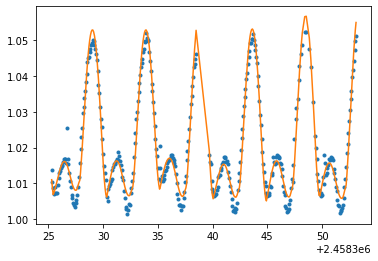

In [34]:
plt.plot(astropy_time.jd,  flux_observed, '.')
plt.plot(astropy_time.jd, gp.predict(flux_observed, return_cov=False))

In [35]:
# sampler = EnsembleSampler(nwalkers, ndim, log_probability)
# sampler.run_mcmc(pos, nsteps, progress=True);

with Pool() as pool:
    sampler = EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True);

100%|██████████| 5000/5000 [01:00<00:00, 82.06it/s]


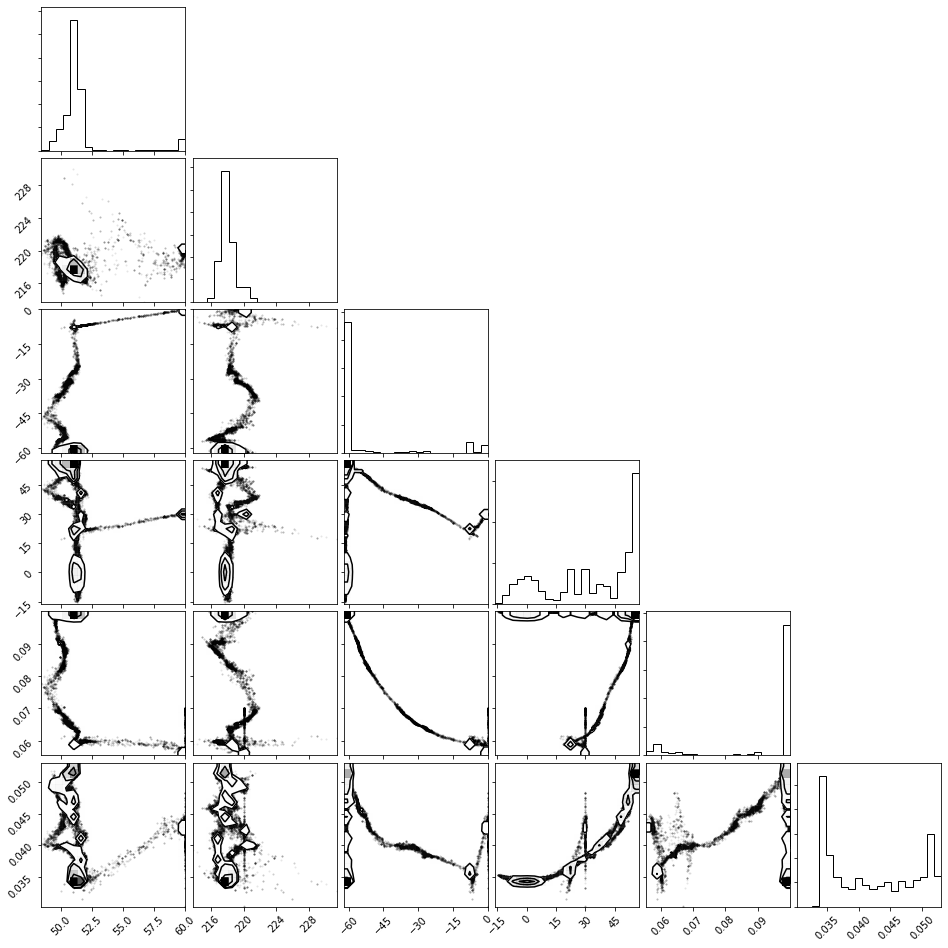

In [36]:
corner(sampler.flatchain);

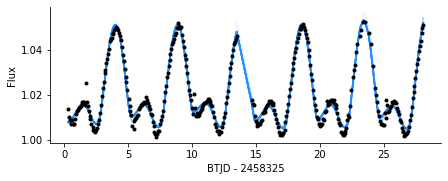

In [37]:
fig, ax = plt.subplots(figsize=(7, 2.5), sharex=True)

btjd_mid = int(astropy_time.jd.min())

ax.plot(astropy_time.jd - btjd_mid, 
           flux_observed, 'k.', zorder=10)

# ax.plot(lc.time + 2457000 - btjd_mid, 
#         lc.flux / np.nanmin(lc.flux), 'k.', zorder=10)

interp_times = np.linspace(astropy_time.jd.min(), astropy_time.jd.max(), 1000)
# star.phases = (interp_times % prot) / prot

for i in np.random.randint(0, len(sampler.flatchain), size=50): 
    
    trial = sampler.flatchain[i, :]
    gp.set_parameter_vector(trial)
    gp_lc = gp.predict(flux_observed, return_cov=False)

    ax.plot(astropy_time.jd - btjd_mid, gp_lc, color='DodgerBlue', alpha=0.1)
    
ax.set(xlabel=f"BTJD - {btjd_mid}", ylabel='Flux')

# for axis in ax: 
for sp in ['right', 'top']: 
    ax.spines[sp].set_visible(False)

fig.savefig('plots/tess_gp.pdf', bbox_inches='tight')
plt.show()

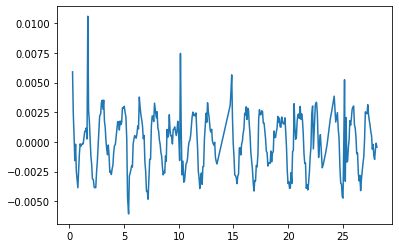

In [38]:
plt.plot(astropy_time.jd - btjd_mid, flux_observed - gp_lc)